In [1]:
# Pytorch installation
!pip3 install torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu116
# Pytorch Geometric installation
!pip install torch-scatter torch-sparse torch-cluster torch-spline-conv torch-geometric -f https://data.pyg.org/whl/torch-1.12.0+cu116.html
# Einops installation (Flexible and powerful tensor operations for readable and reliable code)
!pip install einops

Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu116
^C
   ---------------------------------------- 0.0/2.1 MB ? eta -:--:--
   ---------------------------------------- 0.0/2.1 MB ? eta -:--:--
   ---------------------------------------- 0.0/2.1 MB ? eta -:--:--
    --------------------------------------- 0.0/2.1 MB 435.7 kB/s eta 0:00:05
    --------------------------------------- 0.0/2.1 MB 326.8 kB/s eta 0:00:07
   - -------------------------------------- 0.1/2.1 MB 416.7 kB/s eta 0:00:05
   -- ------------------------------------- 0.1/2.1 MB 467.6 kB/s eta 0:00:05
   -- ------------------------------------- 0.1/2.1 MB 450.6 kB/s eta 0:00:05
   --- ------------------------------------ 0.2/2.1 MB 517.2 kB/s eta 0:00:04
   --- ------------------------------------ 0.2/2.1 MB 562.0 kB/s eta 0:00:04
   ---- ----------------------------------- 0.2/2.1 MB 602.4 kB/s eta 0:00:04
   ----- ---------------------------------- 0.3/2.1 MB 609.2 kB/s eta 0:00:04
   -

In [72]:
import torch
import torch.nn as nn
import time
from torch import optim
import torch.nn.functional as F
import torch_geometric
from torch_geometric.nn import GATConv, GATv2Conv
import torchvision
from einops import rearrange
import wandb
from sklearn import metrics 
import os
import numpy as np
from pathlib import Path

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [24]:
class Residual(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn

    def forward(self, x, **kwargs):
        return self.fn(x, **kwargs) + x

class PreNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.norm = nn.LayerNorm(dim)
        self.fn = fn

    def forward(self, x, **kwargs):
        return self.fn(self.norm(x), **kwargs)

class FeedForward(nn.Module):
    def __init__(self, dim, hidden_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, hidden_dim),
            nn.GELU(),
            nn.Linear(hidden_dim, dim)
        )

    def forward(self, x, **kwargs):
        return self.net(x)
    
class QuickFix(nn.Module):
    def __init__(self, dim, heads, fn):
        super().__init__()
        self.dim = dim
        self.heads = heads
        self.linear = nn.Linear(dim * heads, dim)
        self.fn = fn
        
    def forward(self, x, **kwargs):
        return self.linear(self.fn(x, **kwargs))

In [25]:
class GATTransformer(torch.nn.Module):
    def __init__(self, dim, depth, heads, mlp_dim):
        super().__init__()
        self.layers = nn.ModuleList()
        self.depth = depth
        for _ in range(depth):
            self.layers.append(nn.ModuleList([
                Residual(PreNorm(dim, QuickFix(dim, heads, GATv2Conv(in_channels=dim, out_channels=dim, heads=heads, add_self_loops=False)))),
                Residual(PreNorm(dim, FeedForward(dim, mlp_dim)))
            ]))


    def forward(self, data):
        x, edge_index = data

        for attn, ff in self.layers:
            x = attn(x=x, edge_index=edge_index)
            x = ff(x)

        return x


In [26]:
class GraphViT(nn.Module):
    def __init__(self, image_size, patch_size, num_classes, dim, depth, heads, mlp_dim, channels=3):
        super().__init__()
        assert image_size % patch_size == 0, 'image dimensions must be divisible by the patch size'
        num_patches = (image_size // patch_size) ** 2
        patch_dim = channels * patch_size ** 2
        
        self.dim = dim

        self.patch_size = patch_size
        self.num_patches = num_patches
        self.pos_embedding = nn.Parameter(torch.randn(1, num_patches + 1, dim))
        self.patch_to_embedding = nn.Linear(patch_dim, dim)
        self.cls_token = nn.Parameter(torch.randn(1, 1, dim))
        self.transformer = GATTransformer(dim, depth, heads, mlp_dim)

        self.to_cls_token = nn.Identity()

        self.mlp_head = nn.Sequential(
            nn.Linear(dim, mlp_dim),
            nn.GELU(),
            nn.Linear(mlp_dim, num_classes)
        )

    def forward(self, img, mask=None):
        p = self.patch_size

        x = rearrange(img, 'b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1 = p, p2 = p)
        x = x.to(device)
        x = self.patch_to_embedding(x)
        
        cls_tokens = self.cls_token.expand(img.shape[0], -1, -1)
        cls_tokens = cls_tokens.to(device)
        x = torch.cat((cls_tokens, x), dim=1)
        x += self.pos_embedding
        
    
        x_shape = x.shape
        edge_index = torch.ones((2, x.shape[1]**2*x.shape[0]), dtype=torch.long)
        for i in range(x.shape[0]*x.shape[1]):
            for j in range(x.shape[1]):
                edge_index[0,i*x.shape[1] + j] = i
                edge_index[1,i*x.shape[1] + j] = x.shape[1]*(i // x.shape[1]) + j
        x = x.view((x.shape[0]*x.shape[1], x.shape[2]))
        edge_index = edge_index.to(device)

        
        x = self.transformer([x, edge_index])
        x = x.view(x_shape)
        
        x = self.to_cls_token(x[:,0])
        x = x.to(device)
        
        out = self.mlp_head(x)
        
        return out

In [27]:
from __future__ import print_function, division
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader


In [73]:
BATCH_SIZE_TRAIN = 200
BATCH_SIZE_VAL = 200
BATCH_SIZE_TEST = 200

train_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize([32, 32]),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

valid_transform=transforms.Compose([
            transforms.ToTensor(),
            transforms.Resize([32, 32]),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])

train_set =torchvision.datasets.ImageFolder(root='C:/pythonproject/ShuangLi_1825373/kidney_tumor/train',transform=train_transform)
train_loader =DataLoader(train_set,batch_size=BATCH_SIZE_TRAIN, shuffle=True,num_workers=0)

test_set =torchvision.datasets.ImageFolder(root='C:/pythonproject/ShuangLi_1825373/kidney_tumor/test',transform=valid_transform)
test_loader =DataLoader(test_set,batch_size=BATCH_SIZE_TEST, shuffle=True,num_workers=0)

In [29]:
def train_epoch(model, optimizer, data_loader, loss_history, scheduler, best_model_acc):
    total_samples = len(data_loader.dataset)
    model.train()
    running_loss = 0.0
    old_time = time.time()
    correct_samples = 0
    for i, (data, target) in enumerate(data_loader):
        optimizer.zero_grad()
        output = F.log_softmax(model(data), dim=1)
        target = target.to(device)
        output = output.to(device)
        
        _, pred = torch.max(output, dim=1)
        
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        scheduler.step()
        running_loss += loss.item()
        
        correct_samples += pred.eq(target).sum()
        target = target.cpu().detach().numpy()
        pred = pred.cpu().detach().numpy()
        
        f1_score = metrics.f1_score(target, pred, average='micro')
        
        if i % 100 == 0:
            new_time = time.time()
            print('[' +  '{:5}'.format(i * len(data)) + '/' + '{:5}'.format(total_samples) +
                  ' (' + '{:3.0f}'.format(100 * i / len(data_loader)) + '%)]  Loss: ' +
                  '{:6.4f}'.format(loss.item()))
            loss_history.append(loss.item())
            # wandb.log({
            #     'train_loss': loss.item(),
            #     'train_f1_score': f1_score
            # })
            print(f'Execution time: {new_time - old_time}')
            old_time = time.time()

        
    acc = 100.0 * correct_samples / total_samples
    print(f'Accuracy: ' + '{:4.2f}'.format(acc) + '%')
    return acc

In [30]:
def evaluate(model, data_loader, loss_history):
    model.eval()
    
    total_samples = len(data_loader.dataset)
    correct_samples = 0
    total_loss = 0

    with torch.no_grad():
        for data, target in data_loader:
            res = model(data)
            res = res.to(device)
            output = F.log_softmax(res, dim=1)
            target = target.to(device)
            output = output.to(device)
            loss = F.nll_loss(output, target, reduction='sum')

            _, pred = torch.max(output, dim=1)
                        
            total_loss += loss.item()
            correct_samples += pred.eq(target).sum()
            # LR Scheduler is called per epoch
            scheduler.step()

            
    avg_loss = total_loss / total_samples
    acc = 100.0 * correct_samples / total_samples
    loss_history.append(avg_loss)
    
    target = target.cpu().detach().numpy()
    pred = pred.cpu().detach().numpy()
    f1_score = metrics.f1_score(target, pred, average='micro')
    
    # wandb.log({
    #     'test_loss': loss.item(),
    #     'test_f1_score': f1_score
    # })
    print('\nAverage test loss: ' + '{:.4f}'.format(avg_loss) +
          '  Accuracy:' + '{:5}'.format(correct_samples) + '/' +
          '{:5}'.format(total_samples) + ' (' +
          '{:4.2f}'.format(acc) + '%)\n')
    return acc

In [22]:
N_EPOCHS = 20

Path("models/").mkdir(parents=True, exist_ok=True)

start_time = time.time()

model = GraphViT(image_size=32, patch_size=8, num_classes=2, channels=3,
            dim=128, depth=8, heads=8, mlp_dim=256)
optimizer = optim.AdamW(model.parameters(), lr=0.0001, weight_decay=0.05)
early_stop_tolerance = 10e-4
model = model.to(device)
scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=0.0001, max_lr=0.001, cycle_momentum=False, step_size_up = 1000)

train_loss_history, test_loss_history = [], []
best_model_acc = -1

for epoch in range(1, N_EPOCHS + 1):
    print('Epoch:', epoch)
    train_epoch(model, optimizer, train_loader, train_loss_history, scheduler, best_model_acc)
    print('jj')
    acc = evaluate(model, test_loader, test_loss_history)
    print('ii')
    if acc > best_model_acc:
      best_model_acc = acc
      torch.save(model.state_dict(), os.path.join('models', f'train-4-{epoch}-acc{acc}'))
    if len(train_loss_history) > 2 and np.isclose(train_loss_history[-2], train_loss_history[-1], atol=early_stop_tolerance):
      print(f"Early stop with tolerance {early_stop_tolerance} for losses {train_loss_history[-2]} and {train_loss_history[-1]}")
    print('kk')
# print('Execution time:', '{:5.2f}'.format(time.time() - start_time), 'seconds')

Epoch: 1


C:\Users\kangn\anaconda3\Lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


[    0/   94 (  0%)]  Loss: 0.4335
Execution time: 3.630634307861328
Accuracy: 95.74%
jj


C:\Users\kangn\anaconda3\Lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Average test loss: 0.3604  Accuracy:   15/   17 (88.24%)

ii
kk
Epoch: 2


C:\Users\kangn\anaconda3\Lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


[    0/   94 (  0%)]  Loss: 0.2313
Execution time: 3.2342259883880615
Accuracy: 95.74%
jj


C:\Users\kangn\anaconda3\Lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Average test loss: 0.3911  Accuracy:   15/   17 (88.24%)

ii
kk
Epoch: 3


C:\Users\kangn\anaconda3\Lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


[    0/   94 (  0%)]  Loss: 0.1826
Execution time: 2.849543809890747
Accuracy: 95.74%
jj


C:\Users\kangn\anaconda3\Lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Average test loss: 0.4572  Accuracy:   15/   17 (88.24%)

ii
kk
Epoch: 4


C:\Users\kangn\anaconda3\Lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


[    0/   94 (  0%)]  Loss: 0.1848
Execution time: 3.26171612739563
Accuracy: 95.74%
jj


C:\Users\kangn\anaconda3\Lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Average test loss: 0.5139  Accuracy:   15/   17 (88.24%)

ii
kk
Epoch: 5


C:\Users\kangn\anaconda3\Lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


[    0/   94 (  0%)]  Loss: 0.1974
Execution time: 3.6845457553863525
Accuracy: 95.74%
jj


C:\Users\kangn\anaconda3\Lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Average test loss: 0.5477  Accuracy:   15/   17 (88.24%)

ii
kk
Epoch: 6


C:\Users\kangn\anaconda3\Lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


[    0/   94 (  0%)]  Loss: 0.2067
Execution time: 2.928995370864868
Accuracy: 95.74%
jj


C:\Users\kangn\anaconda3\Lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Average test loss: 0.5584  Accuracy:   15/   17 (88.24%)

ii
kk
Epoch: 7


C:\Users\kangn\anaconda3\Lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


[    0/   94 (  0%)]  Loss: 0.2096
Execution time: 3.1121151447296143
Accuracy: 95.74%
jj


C:\Users\kangn\anaconda3\Lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Average test loss: 0.5495  Accuracy:   15/   17 (88.24%)

ii
kk
Epoch: 8


C:\Users\kangn\anaconda3\Lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


[    0/   94 (  0%)]  Loss: 0.2067
Execution time: 3.1197986602783203
Accuracy: 95.74%
jj


C:\Users\kangn\anaconda3\Lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Average test loss: 0.5252  Accuracy:   15/   17 (88.24%)

ii
kk
Epoch: 9


C:\Users\kangn\anaconda3\Lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


[    0/   94 (  0%)]  Loss: 0.1994
Execution time: 3.0360357761383057
Accuracy: 95.74%
jj


C:\Users\kangn\anaconda3\Lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Average test loss: 0.4905  Accuracy:   15/   17 (88.24%)

ii
kk
Epoch: 10


C:\Users\kangn\anaconda3\Lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


[    0/   94 (  0%)]  Loss: 0.1897
Execution time: 2.605825662612915
Accuracy: 95.74%
jj


C:\Users\kangn\anaconda3\Lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Average test loss: 0.4511  Accuracy:   15/   17 (88.24%)

ii
kk
Epoch: 11


C:\Users\kangn\anaconda3\Lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


[    0/   94 (  0%)]  Loss: 0.1806
Execution time: 3.046213388442993
Accuracy: 95.74%
jj


C:\Users\kangn\anaconda3\Lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Average test loss: 0.4136  Accuracy:   15/   17 (88.24%)

ii
kk
Epoch: 12


C:\Users\kangn\anaconda3\Lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


[    0/   94 (  0%)]  Loss: 0.1752
Execution time: 3.822415351867676
Accuracy: 95.74%
jj


C:\Users\kangn\anaconda3\Lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Average test loss: 0.3854  Accuracy:   15/   17 (88.24%)

ii
kk
Epoch: 13


C:\Users\kangn\anaconda3\Lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


[    0/   94 (  0%)]  Loss: 0.1763
Execution time: 2.9451162815093994
Accuracy: 95.74%
jj


C:\Users\kangn\anaconda3\Lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Average test loss: 0.3709  Accuracy:   15/   17 (88.24%)

ii
kk
Epoch: 14


C:\Users\kangn\anaconda3\Lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


[    0/   94 (  0%)]  Loss: 0.1820
Execution time: 2.8223934173583984
Accuracy: 95.74%
jj


C:\Users\kangn\anaconda3\Lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Average test loss: 0.3669  Accuracy:   15/   17 (88.24%)

ii
kk
Epoch: 15


C:\Users\kangn\anaconda3\Lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


[    0/   94 (  0%)]  Loss: 0.1851
Execution time: 3.141841411590576
Accuracy: 95.74%
jj


C:\Users\kangn\anaconda3\Lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Average test loss: 0.3685  Accuracy:   15/   17 (88.24%)

ii
kk
Epoch: 16


C:\Users\kangn\anaconda3\Lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


[    0/   94 (  0%)]  Loss: 0.1826
Execution time: 2.737769603729248
Accuracy: 95.74%
jj


C:\Users\kangn\anaconda3\Lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Average test loss: 0.3750  Accuracy:   15/   17 (88.24%)

ii
kk
Epoch: 17


C:\Users\kangn\anaconda3\Lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


[    0/   94 (  0%)]  Loss: 0.1774
Execution time: 2.720843553543091
Accuracy: 95.74%
jj


C:\Users\kangn\anaconda3\Lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Average test loss: 0.3866  Accuracy:   15/   17 (88.24%)

ii
kk
Epoch: 18


C:\Users\kangn\anaconda3\Lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


[    0/   94 (  0%)]  Loss: 0.1735
Execution time: 2.9162425994873047
Accuracy: 95.74%
jj


C:\Users\kangn\anaconda3\Lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Average test loss: 0.4015  Accuracy:   15/   17 (88.24%)

ii
kk
Epoch: 19


C:\Users\kangn\anaconda3\Lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


[    0/   94 (  0%)]  Loss: 0.1722
Execution time: 2.68520188331604
Accuracy: 95.74%
jj


C:\Users\kangn\anaconda3\Lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Average test loss: 0.4161  Accuracy:   15/   17 (88.24%)

ii
kk
Epoch: 20


C:\Users\kangn\anaconda3\Lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


[    0/   94 (  0%)]  Loss: 0.1728
Execution time: 2.6534109115600586
Accuracy: 95.74%
jj


C:\Users\kangn\anaconda3\Lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Average test loss: 0.4276  Accuracy:   15/   17 (88.24%)

ii
Early stop with tolerance 0.001 for losses 0.1722315549850464 and 0.17279741168022156
kk


In [31]:
alpha = 1
eps = 4

scale = 1

use_cuda = True

In [34]:
import json
class_idx = json.load(open("C:/pythonproject/ShuangLi_1825373/counterfactual/data/imagenet_class_index.json")) #dictionary
idx2label = [class_idx[str(k)][1] for k in range(len(class_idx))]

In [39]:
def image_folder_custom_label(root, transform, custom_label) :
    
    old_data = dsets.ImageFolder(root = root, transform = transform)
    old_classes = old_data.classes
    
    label2idx = {}
    
    for i, item in enumerate(idx2label) :
        label2idx[item] = i
    
    new_data = dsets.ImageFolder(root = root, transform = transform, 
                                 target_transform = lambda x : custom_label.index(old_classes[x]))
    new_data.classes = idx2label
    new_data.class_to_idx = label2idx

    return new_data

In [59]:
import torchvision.datasets as dsets
transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(), # ToTensor : [0, 255] -> [0, 1]
])

In [60]:
import torch.utils.data as Data
normal_data = image_folder_custom_label(root = 'C:/pythonproject/ShuangLi_1825373/counterfactual/data/imagenet', transform = transform, custom_label = idx2label)
normal_loader = Data.DataLoader(normal_data, batch_size=1, shuffle=False)

In [61]:
def imshow(img, title):
    npimg = img.numpy()
    fig = plt.figure(figsize = (5, 15))
    plt.imshow(np.transpose(npimg,(1,2,0)))
    plt.title(title)
    plt.show()

True Image & True Label


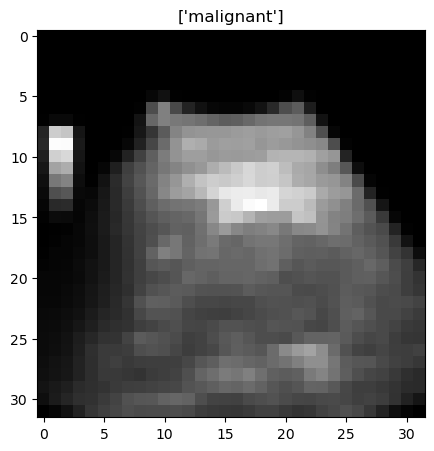

In [62]:
normal_iter = iter(normal_loader)
images, labels = next(normal_iter)
import matplotlib.pyplot as plt
print("True Image & True Label")
imshow(torchvision.utils.make_grid(images, normalize=True), [normal_data.classes[i] for i in labels])

True Image & Predicted Label


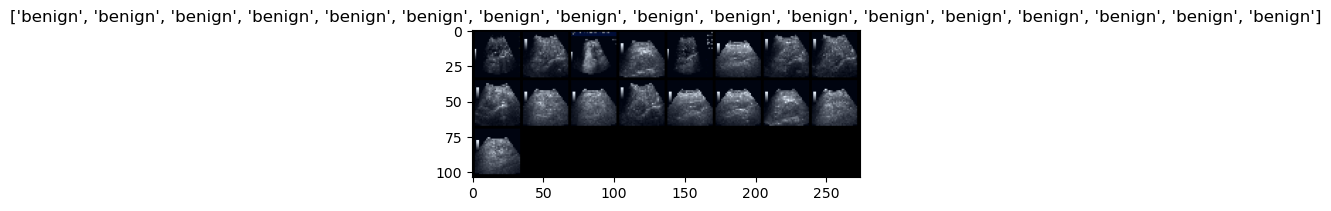

In [74]:
print("True Image & Predicted Label")

model.eval()

correct = 0
total = 0

for images, labels in test_loader:
    
    images = images.to(device)
    labels = labels.to(device)
    outputs = model(images)
    
    _, pre = torch.max(outputs.data, 1)
    
    total += 1
    correct += (pre == labels).sum()
    
    imshow(torchvision.utils.make_grid(images.cpu().data, normalize=True), [normal_data.classes[i] for i in pre])
        

## Adversarial Attack

### 1) Basic iterative_attack

In [75]:
def basic_iterative_attack(model, loss, images, labels, scale, eps, alpha, iters=0) :
    images = images.to(device)
    labels = labels.to(device)
    clamp_max = 255
    
    if iters == 0 :
        # The paper said min(eps + 4, 1.25*eps) is used as iterations
        iters = int(min(eps + 4, 1.25*eps))
                
    if scale :
        eps = eps / 255
        clamp_max = clamp_max / 255
        
    for i in range(iters) :    
        images.requires_grad = True
        outputs = model(images)

        model.zero_grad()
        cost = loss(outputs, labels).to(device)
        cost.backward()

        attack_images = images + alpha*images.grad.sign()
        
        # Clip attack images(X')
        # min{255, X+eps, max{0, X-eps, X'}}
        # = min{255, min{X+eps, max{max{0, X-eps}, X'}}}
        
        # a = max{0, X-eps}
        a = torch.clamp(images - eps, min=0)
        # b = max{a, X'}
        b = (attack_images>=a).float()*attack_images + (a>attack_images).float()*a
        # c = min{X+eps, b}
        c = (b > images+eps).float()*(images+eps) + (images+eps >= b).float()*b
        # d = min{255, c}
        images = torch.clamp(c, max=clamp_max).detach_()
            
    return images

In [76]:
loss = nn.CrossEntropyLoss()

Attack Image & Predicted Label


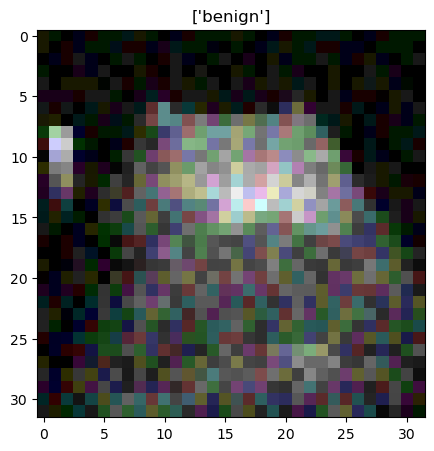

In [77]:
print("Attack Image & Predicted Label")

model.eval()

correct = 0
total = 0

for images, labels in normal_loader:
    
    images = basic_iterative_attack(model, loss, images, labels, scale, eps, alpha).to(device)
    labels = labels.to(device)
    outputs = model(images)
    
    _, pre = torch.max(outputs.data, 1)
    
    total += 1
    correct += (pre == labels).sum()
    
    imshow(torchvision.utils.make_grid(images.cpu().data, normalize=True), [normal_data.classes[i] for i in pre])

### 2) Least likely class attack

In [78]:
def ll_class_attack(model, loss, images, scale, eps, alpha, iters=0) :
    images = images.to(device)    
    outputs = model(images)
    _, labels = torch.min(outputs.data, 1)
    labels = labels.detach_()
        
    clamp_max = 255
    
    if iters == 0 :
        # The paper said min(eps + 4, 1.25*eps) is used as iterations
        iters = int(min(eps + 4, 1.25*eps))
        
    if scale :
        eps = eps / 255
        clamp_max = clamp_max / 255
        
    for i in range(iters) :    
        images.requires_grad = True
        outputs = model(images)

        model.zero_grad()
        cost = loss(outputs, labels).to(device)
        cost.backward()

        attack_images = images - alpha*images.grad.sign()
        
        # Clip attack images(X')
        # min{255, X+eps, max{0, X-eps, X'}}
        # = min{255, min{X+eps, max{max{0, X-eps}, X'}}}
        
        # a = max{0, X-eps}
        a = torch.clamp(images - eps, min=0)
        # b = max{a, X'}
        b = (attack_images>=a).float()*attack_images + (a>attack_images).float()*a
        # c = min{X+eps, b}
        c = (b > images+eps).float()*(images+eps) + (images+eps >= b).float()*b
        # d = min{255, c}
        images = torch.clamp(c, max=clamp_max).detach_()
    
    return images

In [69]:
loss = nn.CrossEntropyLoss()

Attack Image & Predicted Label


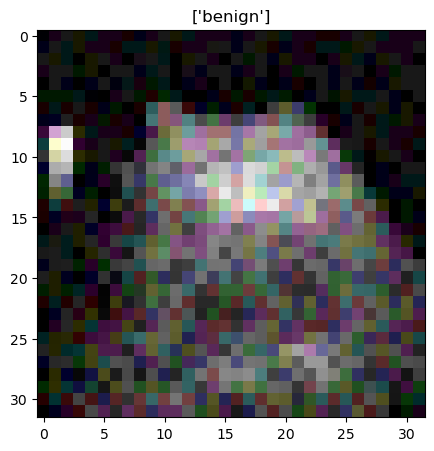

In [71]:
print("Attack Image & Predicted Label")

model.eval()

correct = 0
total = 0

for images, labels in normal_loader:
    
    images = ll_class_attack(model, loss, images, scale, eps, alpha).to(device)
    labels = labels.to(device)
    outputs = model(images)
    
    _, pre = torch.max(outputs.data, 1)
    
    total += 1
    correct += (pre == labels).sum()
    
    imshow(torchvision.utils.make_grid(images.cpu().data, normalize=True), [normal_data.classes[i] for i in pre])
